In [1]:
import numpy as np #библиотека для работы с матрицами
import pandas as pd #библиотека для подробного представление таблиц

import matplotlib.pyplot as plt #библиотека для построения графиков
import seaborn as sns #тоже библиотека для построения графиков, на базе предыдущей, но чуть помощнее
from IPython.display import clear_output #импортируем функцию очистки вывода
sns.set_theme(palette='Set2', font_scale=1.5) #изменяет глобальные настройки по умолчанию для всех графиков
from sklearn.model_selection import train_test_split #функция, которая разделяет выборку на тестовую и тренировочную для модели машинного обучения

import torch #платформа глубокого обучения с открытым исходным кодом
from torch import nn, optim #импортируем слои для нейронки и пакет для алгоритмов оптимизации

print(torch.__version__)#печатает установленную версию torch (с которой мы будем работать)

2.2.1+cu121


Сделаем одномерную линейную регрессию на датасете <a href="http://lib.stat.cmu.edu/datasets/boston" target="_blank">boston</a>. Этот датасет представляет собой набор данных конца 70-х годов прошлого века для предсказания цены недвижимости в Бостоне.

Скачиваем данные.

In [2]:
def load_boston(): #создаем функцию для выгрузки данных из датасета, который хранится по ссылке ниже
    # выделяем признаки и таргет
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)#создаем таблицу с помощью библиотеки пандас, помещаем в нее данные из boston.csv
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])#присоединяем данные (признаки) по горизонтальной оси в один массив numpy
    target = raw_df.values[1::2, 2]#выгружаем в отдельный массив выходные значения (таргет)
    return data, target#возвращаем как результат выполнения функции

In [3]:
data, target = load_boston()#создаем переменные в основной части программы, вызыем функцию и сохраняем в них результат выполнения. Мы получили данные, с которыми будем работать

In [4]:
data.shape, target.shape#получаем характеристики массивов (первое число - кол-во строк, второе число - кол-во столбцов)

((506, 13), (506,))

Будем рассматривать зависимость таргета, т.е. медианной стоимости домов в тысячах долларов, от последнего признака, т.е. процента населения людей с низким уровнем дохода.

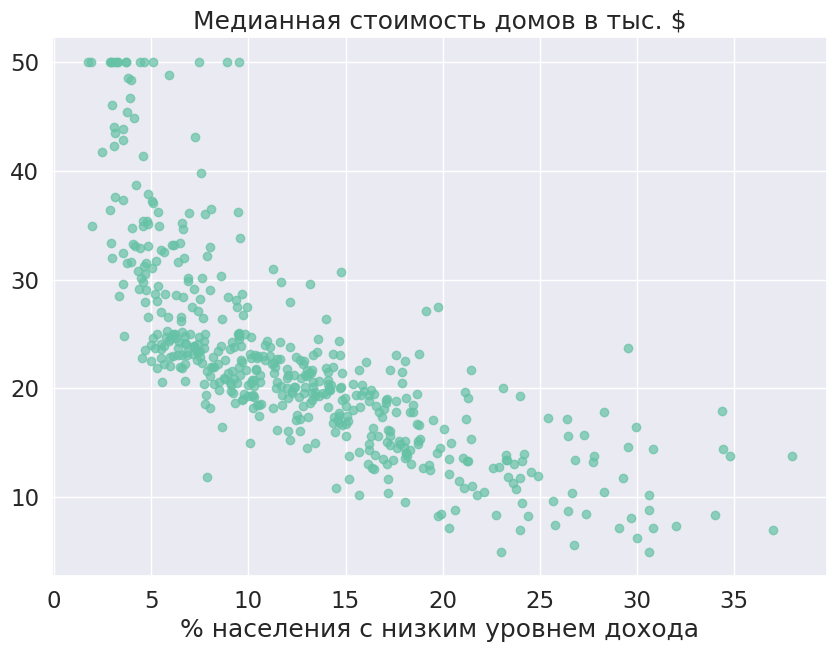

In [5]:
plt.figure(figsize=(10, 7))#создаем график, задаем параметры (10 - ширина, 7 - высота в дюймах)
plt.scatter(data[:, -1], target, alpha=0.7)#строим диаграмму рассеяния, по Ох - последний из признаков из массива data (% населения с низким уровнем дохода), по Oy - таргет (медианная стоимость домов)
plt.xlabel('% населения с низким уровнем дохода')#называем ось Ох
plt.title('Медианная стоимость домов в тыс. $');#называем ось Оу

В данном случае предсказание модели задается следующим образом: $$\widehat{y}(x) = wx + b,$$
где $w, b \in \mathbb{R}$ &mdash; обучаемые параметры модели. Это обычная линейная модель.


In [6]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=1)
    )#создаем односвязную линейную модель
model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

Инициализируем веса модели нулевыми тензорами.

In [7]:
for p in model.parameters():#перебор параметров созданной модели
    p.data = torch.FloatTensor([[0]])#для каждого параметра инициализируем вес нулевым тензором
    print(p.data)#выводим результат

tensor([[0.]])
tensor([[0.]])


Зададим признак $X$ и таргет $Y$ в виде `torch`-тензоров. Помимо этого для того, чтобы работать с нашей моделью, нам необходимо поменять размерность `x` и `y`.

In [8]:
print(data[:, -1]/10)

x = torch.FloatTensor(data[:, -1]/10).reshape(-1, 1)
y = torch.FloatTensor(target).reshape(-1, 1)

x.shape, y.shape

[0.498 0.914 0.403 0.294 0.533 0.521 1.243 1.915 2.993 1.71  2.045 1.327
 1.571 0.826 1.026 0.847 0.658 1.467 1.169 1.128 2.102 1.383 1.872 1.988
 1.63  1.651 1.481 1.728 1.28  1.198 2.26  1.304 2.771 1.835 2.034 0.968
 1.141 0.877 1.013 0.432 0.198 0.484 0.581 0.744 0.955 1.021 1.415 1.88
 3.081 1.62  1.345 0.943 0.528 0.843 1.48  0.481 0.577 0.395 0.686 0.922
 1.315 1.444 0.673 0.95  0.805 0.467 1.024 0.81  1.309 0.879 0.672 0.988
 0.552 0.754 0.678 0.894 1.197 1.027 1.234 0.91  0.529 0.722 0.672 0.751
 0.962 0.653 1.286 0.844 0.55  0.57  0.881 0.82  0.816 0.621 1.059 0.665
 1.134 0.421 0.357 0.619 0.942 0.767 1.063 1.344 1.233 1.647 1.866 1.409
 1.227 1.555 1.3   1.016 1.621 1.709 1.045 1.576 1.204 1.03  1.537 1.361
 1.437 1.427 1.793 2.541 1.758 1.481 2.726 1.719 1.539 1.834 1.26  1.226
 1.112 1.503 1.731 1.696 1.69  1.459 2.132 1.846 2.416 3.441 2.682 2.642
 2.929 2.78  1.665 2.953 2.832 2.145 1.41  1.328 1.212 1.579 1.512 1.502
 1.614 0.459 0.643 0.739 0.55  0.173 0.192 0.332 1.1

(torch.Size([506, 1]), torch.Size([506, 1]))

Разобъём данные на тренировочную и валидационную выборки в соотношении 4:1

In [9]:
X_train, X_val, y_train, y_val = train_test_split(x, y, train_size=4/5, random_state=42)#из важного - разбиваем рандомно

Зададим оптимизируемую функцию / функцию ошибки / лосс. В нашем случае это будет MSE:

$$
\mathrm{MSE}(\widehat{y}, y) = \frac{1}{n} \sum_{i=1}^n \left(\widehat{y}_i - y_i\right)^2.
$$

Воспользуемся реализацией из пакета PyTorch

In [10]:
optim_func = nn.MSELoss()#MSE - среднеквадратичная ошибка,
#то есть среднеквадратичное отклонение между истинными и предсказанными значениями
#чувствительна к выбросам (и +, и -), неравномерные веса ошибок (-)
#если равна нулю, то предсказание идеальное

Будем оптимизировать функцию ошибки с помощью метода `SGD` из `torch`, который реализует стохастический градиентный спуск. Он принимает на вход параметры модели, их мы можем получить, вызвав метод `parameters` у модели, и скорость обучения `lr`, которую мы обозначали ранее как $\eta$.

Установим скорость обучения на уровне $0.01$ для всех параметров сразу.

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01)#

Обучим полученную модель на наших данных. Теперь обновления значений параметров происходят с помощью вызова `optimzer.step()`, а зануление градиентов &mdash; с помощью `optimizer.zero_grad()`.

In [12]:
def show_progress(x, y, y_pred, loss):#
    '''
    Визуализация процесса обучения.

    x, y -- объекты и таргеты обучающей выборки;
    y_pred -- предсказания модели;
    loss -- текущее значение ошибки модели.
    '''

    # Открепим переменную от вычислительного графа перед отрисовкой графика
    y_pred = y_pred.detach()

    # Превратим тензор размерности 0 в число
    loss = loss.item()

    # Стираем предыдущий вывод в тот момент, когда появится следующий
    clear_output(wait=True)

    # Строим новый график
    plt.figure(figsize=(10, 7))#задаем параметры графика
    plt.scatter(x, y, alpha=0.75)#строим диаграмму рассеяния для обучающей выборки
    plt.scatter(x, y_pred, color='orange', linewidth=5)#строим диаграмму рассеяния для предсказаний
    plt.xlabel('% населения с низким уровнем дохода')#задаем название оси oX
    plt.title('Медианная стоимость домов в тыс. $')#заголовок графика
    plt.show()#выводим график

    print(f"MSE = {loss:.3f}")#выводим среднеквадратичную ошибку

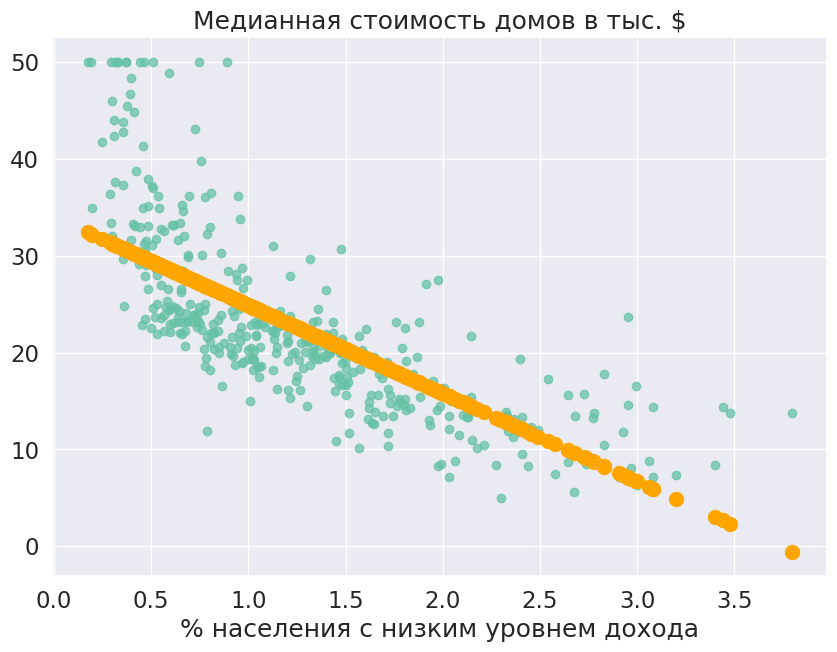

MSE = 39.948


In [13]:
num_iter = 1000#
for i in range(num_iter):#
    # Шаг 1.
    # Forward pass: предсказание модели по обучающим данным
    y_pred = model(X_train)

    # Шаг 2.
    # Вычисление оптимизируемой функции (MSE) по предсказаниям
    loss = optim_func(y_pred, y_train)

    # Шаг 3.
    # Backward pass: вычисление градиентов оптимизируемой функции
    # по всем параметрам модели
    loss.backward()

    # Шаг 4.
    # Оптимизация: обновление параметров по формулам соответствующего
    # метода оптимизации, используются вычисленные ранее градиенты
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()

    # График + вывод MSE через каждые 10 итераций
    if (i + 1) % 10 == 0:
        show_progress(X_train, y_train, y_pred, loss)

Посчитаем MSE на валидационной выборке

In [14]:
print(f'Значение MSE на валидационной выборке: {optim_func(model(X_val), y_val).item():.3}')#

Значение MSE на валидационной выборке: 33.1


### Улучшение модели

Попробуем усложнить модель, добавив еще один слой. Тем самым модель примет следующий вид

$$\widehat{y}(x) = w_2u(x) + b_2,$$

$$u(x) = \sigma(w_1x + b_1),$$

$$\sigma(x) = \text{ReLU}(x) = \begin{equation*}\begin{cases}x, \; x \ge 0, \\ 0, \; \text{иначе,} \end{cases} \end{equation*}$$

$w_1, b_1 \in \mathbb{R}$ &mdash; обучаемые параметры первого слоя, $w_2, b_2 \in \mathbb{R}$ &mdash; обучаемые параметры второго слоя, $\sigma(x)$ &mdash; функция активации, в данном случае `ReLU`.

Соберём все модули в одну модель. Теперь, помимо одного линейного слоя, у нас есть функция активации и второй линейный слой.

In [15]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=1),
    nn.ReLU(),
    nn.Linear(in_features=1, out_features=1)
    )
model#теперь у нас двусвязная модель

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)

Инициализируем веса

In [16]:
for name, param in model.named_parameters():
    param.data = torch.FloatTensor([[1]])
    print(name)
    print(param.data)

0.weight
tensor([[1.]])
0.bias
tensor([[1.]])
2.weight
tensor([[1.]])
2.bias
tensor([[1.]])


Имена `0.weight` и `0.bias` соответствуют весу $w_1$ и сдвигу $b_1$ первого слоя, аналогично, `2.weight` и `2.bias` соответствуют весу $w_2$ и сдвигу $b_2$ второго слоя.

Запустим модель на обучение.

In [17]:
optim_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_iter = 1000
for i in range(num_iter):
    # Шаг 1.
    # Forward pass: предсказание модели по обучающим данным
    y_pred = model(X_train)

    # Шаг 2.
    # Вычисление оптимизируемой функции (MSE) по предсказаниям
    loss = optim_func(y_pred, y_train)

    # Шаг 3.
    # Backward pass: вычисление градиентов оптимизируемой функции
    # по всем параметрам модели
    loss.backward()

    # Шаг 4.
    # Оптимизация: обновление параметров по формулам соответствующего
    # метода оптимизации, используются вычисленные ранее градиенты
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()

 MSE на валидации:

In [18]:
print(f'Значение MSE на валидационной выборке: {optim_func(model(X_val), y_val).item():.3}')

Значение MSE на валидационной выборке: 31.9


### Ещё больше усложним модель

К предыдущей модели добавим ещё один слой активации и ещё один линейный слой.

Реализуем функцию, по аналогии с show_progress, которая будет отрисовывать не только предсказания модели, но еще и её лосс за все предыдущие итерации обучения, а также адаптируем шаблон функции обучения под эту задачу

In [19]:
def show_progress(x, y, y_pred, losses):
    '''
    Визуализация процесса обучения.

    x, y -- объекты и таргеты обучающей выборки;
    y_pred -- предсказания модели;
    losses -- значение ошибки модели со всех итераций обучения.
    '''

    # Открепим переменную от вычислительного графа перед отрисовкой графика
    y_pred = y_pred.detach()

    # Стираем предыдущий вывод в тот момент, когда появится следующий
    clear_output(wait=True)

    # Строим новый график
    fig, ax = plt.subplots(2, 1, figsize = (10, 10))
    # График предсказаний
    ax[0].scatter(x, y, alpha=0.75)
    ax[0].scatter(x, y_pred, color='orange', linewidth=5)
    ax[0].set_xlabel('% населения с низким уровнем дохода')
    ax[0].set_title('Медианная стоимость домов в тыс. $')

    #Теперь добавляем график с лосс-функцией
    ax[1].plot(losses)

    # Добавляем заголовок и подписи по осям
    ax[1].set_xlabel('Итерация')
    ax[1].set_title('Функция ошибки')

    # Чтобы подписи не перекрывались
    fig.tight_layout()

    plt.show()

    print(f"MSE = {losses[-1]:.3f}")

Обучаем модель

In [20]:
model = nn.Sequential(
    nn.Linear(in_features=1, out_features=1),
    nn.ReLU(),
    nn.Linear(in_features=1, out_features=1),
    nn.ReLU(),
    nn.Linear(in_features=1, out_features=1)
    )
model#теперь модель трехслойная

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1, out_features=1, bias=True)
)

In [21]:
for name, param in model.named_parameters():#
    param.data = torch.FloatTensor([[1]])#
    print(name)#
    print(param.data)#

0.weight
tensor([[1.]])
0.bias
tensor([[1.]])
2.weight
tensor([[1.]])
2.bias
tensor([[1.]])
4.weight
tensor([[1.]])
4.bias
tensor([[1.]])


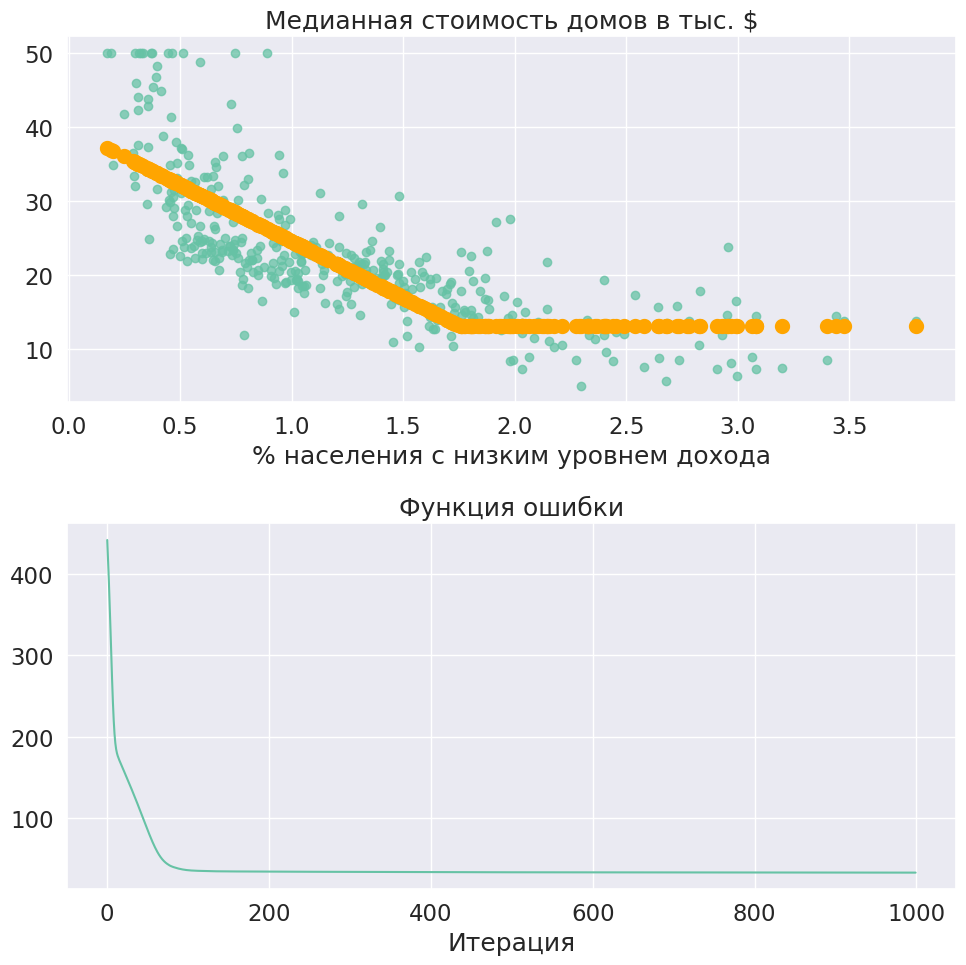

MSE = 33.661


In [22]:
optim_func = nn.MSELoss()#
optimizer = optim.SGD(model.parameters(), lr=1e-3)#
num_iter = 1000
losses = []
for i in range(num_iter):
    # Шаг 1.
    # Forward pass: предсказание модели по обучающим данным
    y_pred = model(X_train)

    # Шаг 2.
    # Вычисление оптимизируемой функции (MSE) по предсказаниям
    loss = optim_func(y_pred, y_train)
    losses.append(loss.item())

    # Шаг 3.
    # Backward pass: вычисление градиентов оптимизируемой функции
    # по всем параметрам модели
    loss.backward()

    # Шаг 4.
    # Оптимизация: обновление параметров по формулам соответствующего
    # метода оптимизации, используются вычисленные ранее градиенты
    optimizer.step()

    # Зануление градиентов
    optimizer.zero_grad()


    if (i + 1) % 40 == 0:
        show_progress(X_train, y_train, y_pred, losses)

* Функция ошибки сильно падает в первые 100 итераций и почти не меняется далее, то есть для градиентного спуска достаточно брать 100 итераций.
* MSE по сравнению с предыдущим результатом не улучшилось, то есть для данного примера можно не добавлять новые слои нейронов (достаточно однослойной модели, то есть просто линейной регрессии).